In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import copy
import cv2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
#from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import RandomFlip, RandomRotation

from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix


2025-07-13 22:15:17.847282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752444918.077808      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752444918.151330      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
! conda install -y gdown

/bin/bash: line 1: conda: command not found


In [3]:
import gdown

# a file
url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/bwh3zbpkpv-1.zip"
gdown.download(url)

Downloading...
From: https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/bwh3zbpkpv-1.zip
To: /kaggle/working/bwh3zbpkpv-1.zip
100%|██████████| 8.44G/8.44G [05:58<00:00, 23.6MB/s]  


'bwh3zbpkpv-1.zip'

In [4]:
import zipfile
import os

zip_path = "/kaggle/working/bwh3zbpkpv-1.zip"
extract_path = "/kaggle/working/bwh3zbpkpv"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped to:", extract_path)


Unzipped to: /kaggle/working/bwh3zbpkpv


In [35]:
# List the top-level files and folders
for root, dirs, files in os.walk(extract_path):
    print("Current folder:", root)
    print("Subfolders:", dirs)
    print("Files:", files)
    break  # Remove this 'break' to see everything recursively


Current folder: /kaggle/working/bwh3zbpkpv
Subfolders: ['Dataset for Crop Pest and Disease Detection']
Files: []


In [36]:
import os

inner_folder = os.path.join(extract_path, "Dataset for Crop Pest and Disease Detection")

for root, dirs, files in os.walk(inner_folder):
    print("Current folder:", root)
    print("Subfolders:", dirs)
    print("Files:", files)
    break  # remove break if you want to go deeper


Current folder: /kaggle/working/bwh3zbpkpv/Dataset for Crop Pest and Disease Detection
Subfolders: ['Raw Data', 'CCMT Dataset-Augmented']
Files: []


In [37]:
ccmt_path = os.path.join(inner_folder, "CCMT Dataset-Augmented")

for root, dirs, files in os.walk(ccmt_path):
    print("Current folder:", root)
    print("Subfolders:", dirs)
    print("Files:", files)
    break


Current folder: /kaggle/working/bwh3zbpkpv/Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented
Subfolders: ['Cashew', 'Maize', 'Cassava', 'Tomato']
Files: []


In [38]:
train_dir = os.path.join(
    inner_folder,
    "CCMT Dataset-Augmented",
    "Cashew",
    "train_set"
)

test_dir = os.path.join(
    inner_folder,
    "CCMT Dataset-Augmented",
    "Cashew",
    "test_set"
)

# validation_dir = os.path.join(
#     inner_folder,
#     "Raw Data",
#     "CCMT Dataset",
#     "Cashew",
# )
validation_dir = os.path.join(
    inner_folder,
    "CCMT Dataset-Augmented",
    "Cashew",
    "test_set"
)

In [39]:
# from google.colab import drive
# drive.mount('/content/drive')

# define train forms

In [41]:
import os

train_data = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # ✅ only process directories
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            train_data.append((file_path, class_name))

In [42]:
train_df = pd.DataFrame(train_data, columns=['File_Path', 'Class_Name'])
train_df.head()

,File_Path,Class_Name
0,/kaggle/working/bwh3zbpkpv/Dataset for Crop Pe...,healthy5877
1,/kaggle/working/bwh3zbpkpv/Dataset for Crop Pe...,healthy5877
2,/kaggle/working/bwh3zbpkpv/Dataset for Crop Pe...,healthy5877
3,/kaggle/working/bwh3zbpkpv/Dataset for Crop Pe...,healthy5877
4,/kaggle/working/bwh3zbpkpv/Dataset for Crop Pe...,healthy5877


In [43]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_df['Class_ID'] = encoder.fit_transform(train_df['Class_Name'])
train_df.head()

,File_Path,Class_Name,Class_ID
0,/kaggle/working/bwh3zbpkpv/Dataset for Crop Pe...,healthy5877,2
1,/kaggle/working/bwh3zbpkpv/Dataset for Crop Pe...,healthy5877,2
2,/kaggle/working/bwh3zbpkpv/Dataset for Crop Pe...,healthy5877,2
3,/kaggle/working/bwh3zbpkpv/Dataset for Crop Pe...,healthy5877,2
4,/kaggle/working/bwh3zbpkpv/Dataset for Crop Pe...,healthy5877,2


In [44]:
#train_df['Class_Name'].value_counts()

Class_Name
healthy5877        5877
red rust4751       4751
leaf miner3466     3466
anthracnose3102    3102
gumosis1714        1714
Name: count, dtype: int64

In [45]:
train_df['Class_ID'].value_counts()

Class_ID
2    5877
4    4751
3    3466
0    3102
1    1714
Name: count, dtype: int64

#take a look at the various diseases

In [46]:

#name is the title
def plotimage(desired_class: str,name):
    desired_class_df = train_df[train_df['Class_Name'] == desired_class]

    num_images_to_plot = 4

    fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

    for i, (index, row) in enumerate(desired_class_df.head(num_images_to_plot).iterrows()):
        image_path = row['File_Path']
        image = load_img(image_path)

        axes[i].imshow(image)
        axes[i].set_title(f"Image {i+1}: {name}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [47]:
#plotimage('healthy','HEALTHY')

In [48]:
#plotimage('red rust','RED RUST')

In [49]:
#plotimage('leaf miner','LEAF MINER')

In [50]:
#plotimage('anthracnose','ANTHRACNOSE')

In [51]:
#plotimage('gumosis','GUMOSIS')

# xception model

In [52]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

batch_size = 32

In [53]:
#model1 = Xception(include_top=False,input_shape=(299, 299, 3), weights='imagenet')

In [54]:
#input_shape= (299, 299)

In [55]:

datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)


generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

generator_val = datagen_val.flow_from_directory(directory=validation_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 18910 images belonging to 5 classes.
Found 6901 images belonging to 5 classes.
Found 6901 images belonging to 5 classes.


In [56]:
math.ceil(generator_train.samples)

18910

In [57]:
next(generator_train)[1]

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

# Xception deep network

In [58]:
conv_model = Model(inputs=model1.input, outputs=model1.output)

In [59]:

new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation='relu'))
new_model.add(Dense(5, activation='softmax'))

In [60]:
new_model.compile(optimizer= opt, loss=loss, metrics=metrics)

In [61]:

num_iters = 30000
num_batches_train = generator_train.n // batch_size

epochs = int(num_iters / num_batches_train)
epochs = 10
print("Epoch: ",epochs)
desired_train_accuracy = 0.99

#steps_per_epoch = generator_train.n // batch_size
#steps_val = generator_val.n // batch_size

steps_per_epoch = math.ceil(generator_train.n / batch_size)  
steps_val = math.ceil(generator_val.n / batch_size)  

print("Steps_per_epoch: ",steps_per_epoch)
print("Steps_val: ",steps_val)

Epoch:  10
Steps_per_epoch:  591
Steps_val:  216


# fit model

In [62]:

Checkpoint = ModelCheckpoint("xception_cassava.keras", monitor="val_accuracy", save_best_only=True, mode="max")
#EarlyStop = EarlyStopping(monitor="val_accuracy", baseline=desired_train_accuracy, patience=10, restore_best_weights=True, mode="auto")
EarlyStop = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True,mode="auto")
history = new_model.fit(generator_train,
                        epochs=epochs,
                        callbacks=[Checkpoint, EarlyStop],
                        steps_per_epoch=steps_per_epoch,
                        validation_data=generator_val,
                        validation_steps=steps_val)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.8337 - loss: 0.5784

E0000 00:00:1752446807.344235      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752446807.583575      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752446808.173705      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752446808.437133      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


591/591 ━━━━━━━━━━━━━━━━━━━━ 519s 798ms/step - accuracy: 0.8338 - loss: 0.5780 - val_accuracy: 0.9339 - val_loss: 0.2287
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 436s 737ms/step - accuracy: 0.9674 - loss: 0.1131 - val_accuracy: 0.9320 - val_loss: 0.2619
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 444s 751ms/step - accuracy: 0.9757 - loss: 0.0770 - val_accuracy: 0.9464 - val_loss: 0.2076
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 446s 754ms/step - accuracy: 0.9820 - loss: 0.0546 - val_accuracy: 0.9584 - val_loss: 0.1669
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 433s 732ms/step - accuracy: 0.9846 - loss: 0.0491 - val_accuracy: 0.9502 - val_loss: 0.2052
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 447s 756ms/step - accuracy: 0.9872 - loss: 0.0433 - val_accuracy: 0.9606 - val_loss: 0.2149
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 441s 745ms/step - accuracy: 0.9862 - loss: 0.0471 - val_accuracy: 0.9477 - val_loss: 0.2561
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 422s 714ms/step - accuracy: 0.9883 - loss: 0.03

In [63]:
# save exception model

In [64]:
#import shutil

#shutil.move("xception_cassava.keras", "/kaggle/working/xception_cassava.keras")

'/kaggle/working/xception_cassava.keras'

In [65]:
import os

print(os.listdir('/kaggle/working'))


['.virtual_documents', 'bwh3zbpkpv', 'xception_cassava.keras', 'bwh3zbpkpv-1.zip']


In [66]:
new_model.save('/kaggle/working/my_model.h5')

In [67]:
import os

print(os.listdir('/kaggle/working'))


['.virtual_documents', 'bwh3zbpkpv', 'my_model.h5', 'xception_cassava.keras', 'bwh3zbpkpv-1.zip']


In [68]:
from IPython.display import FileLink

FileLink('/kaggle/working/my_model.h5') 

/kaggle/working/my_model.h5

In [81]:
import shutil

shutil.make_archive('/kaggle/working/my_model', 'zip', '/kaggle/working', 'my_model.h5')


'/kaggle/working/my_model.zip'

In [80]:
# Delete the big zip file (if already extracted)
import os
os.remove('/kaggle/working/bwh3zbpkpv-1.zip')

# Now try again:
import shutil
shutil.make_archive('/kaggle/working/my_model', 'zip', '/kaggle/working', 'my_model.h5')


'/kaggle/working/my_model.zip'

In [78]:
'''
def plot_training(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(new_model.history.history['accuracy'], label='Train Accuracy')
    plt.plot(new_model.history.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(0.99, color='red', linestyle='--', alpha=0.5, label='99% Target')
    plt.title('Accuracy Progress')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(new_model.history.history['loss'], label='Train Loss')
    plt.plot(new_model.history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Progress')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call this after each epoch
class PlotCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        plot_training(history)
        '''

In [71]:
from tensorflow.keras.models import load_model

# Load your saved model
model = load_model('/kaggle/working/my_model.h5') 

In [72]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

def predict_image_class(img_path):
    # Load and resize image
    img = image.load_img(img_path, target_size=(299, 299))
    
    # Convert to array and preprocess
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)
    
    return predicted_class, confidence

In [73]:
# Get class names from your validation generator
class_names = list(generator_val.class_indices.keys())
class_mapping = {i: name for i, name in enumerate(class_names)}

print("Class Mapping:")
for idx, name in class_mapping.items():
    print(f"{idx}: {name}")

Class Mapping:
0: anthracnose
1: gumosis
2: healthy
3: leaf miner
4: red rust


In [74]:
import os
import random
from glob import glob

# Get all image paths from raw data directory
all_images = []
for root, dirs, files in os.walk(validation_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_images.append(os.path.join(root, file))

# Select random images
num_samples = 8
sample_images = random.sample(all_images, num_samples)

# sample predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


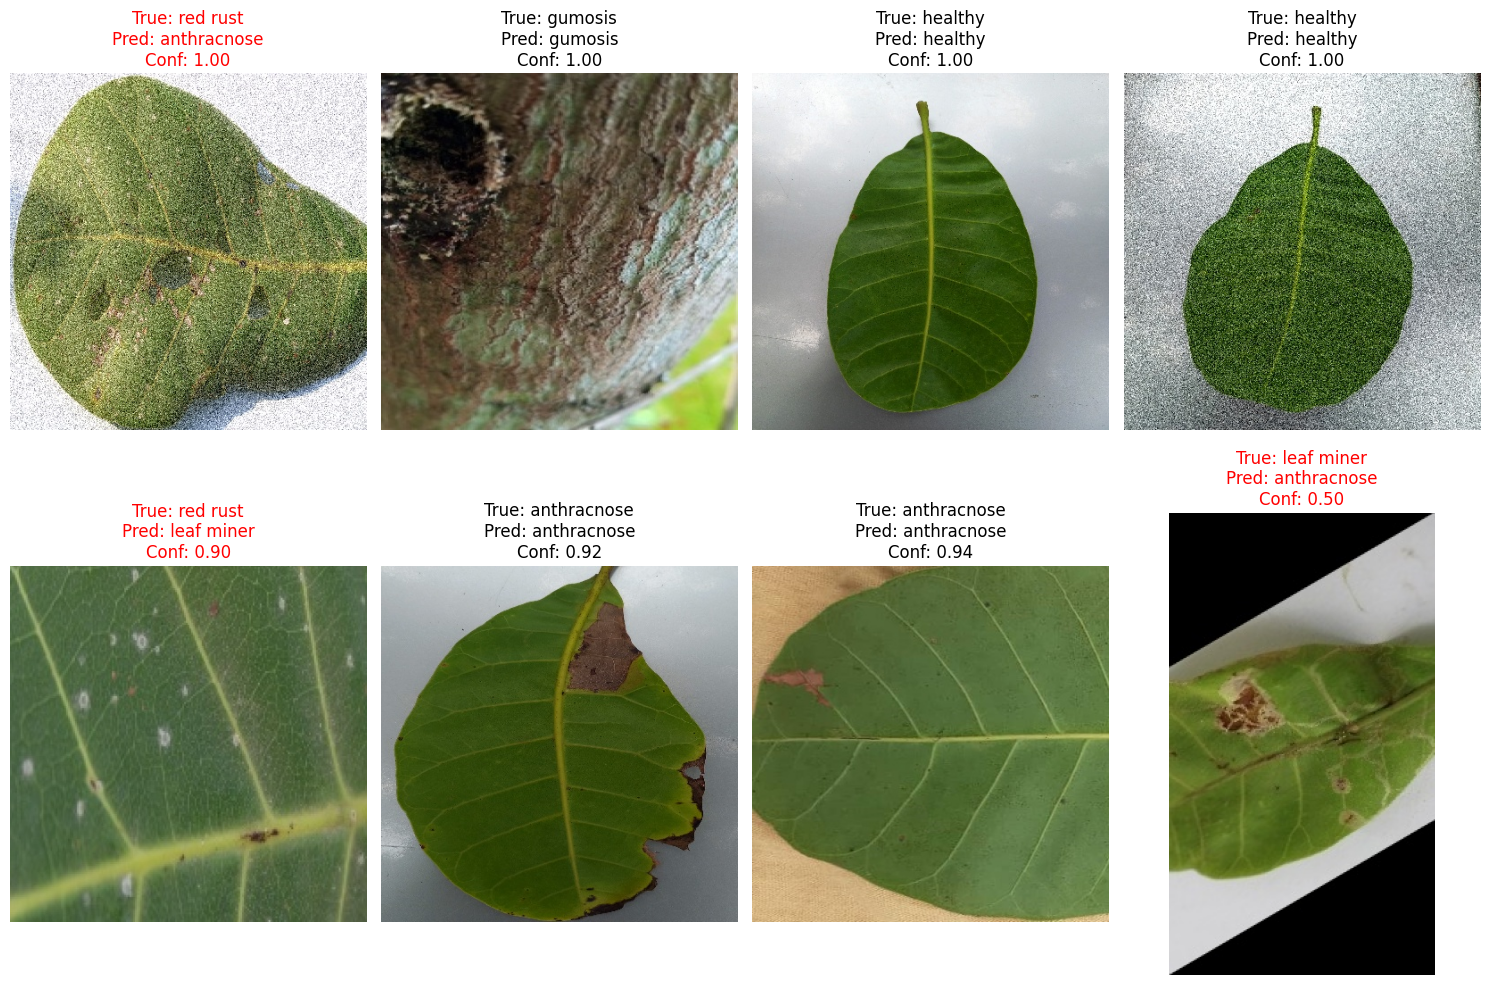

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i, img_path in enumerate(sample_images):
    # Get true class from directory structure
    true_class = img_path.split('/')[-2]
    
    # Predict
    pred_class_idx, confidence = predict_image_class(img_path)
    pred_class = class_mapping[pred_class_idx]
    
    # Plot
    img = image.load_img(img_path)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}")
    plt.axis('off')
    
    # Highlight incorrect predictions in red
    if true_class != pred_class:
        plt.gca().set_title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}", 
                            color='red')

plt.tight_layout()
plt.show()

# classification report

In [ ]:
''''from sklearn.metrics import classification_report

# Get all validation images
all_val_images = []
true_labels = []
for root, dirs, files in os.walk(validation_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_val_images.append(os.path.join(root, file))
            true_labels.append(os.path.basename(root))

# Predict all
pred_labels = []
for img_path in all_val_images:
    pred_class_idx, _ = predict_image_class(img_path)
    pred_labels.append(class_mapping[pred_class_idx])

# Classification report
print(classification_report(true_labels, pred_labels, target_names=class_names))
'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━